In [22]:
import torch
import torch.nn as nn
import numpy as np
from ADDA.data.dataset import get_dataloader
from ADDA.data import augmentations
# source domain: model_f
model_f_train_data_path = "I_train.npy"
model_f_train_labels_path = "I_train_label.npy"

model_f_test_data_path = "I_test.npy"#val
model_f_test_labels_path =  "I_test_label.npy"

model_f_test2_data_path = "I_test2.npy"#test
model_f_test2_labels_path =  "I_test2_label.npy"
# target domain: model_j
model_j_train_data_path = "II_train.npy"
model_j_train_labels_path ="II_train_label.npy"

model_j_test_data_path = "II_test.npy"
model_j_test_labels_path = "II_test_label.npy"

model_j_test2_data_path = "III_test2.npy"
model_j_test2_labels_path =  "II_test2_label.npy"
# test domain: model_k
model_k_train_data_path = "III_train.npy"
model_k_train_labels_path ="II_train_label.npy"

model_k_test_data_path = "III_test.npy"
model_k_test_labels_path = "III_test_label.npy"

model_k_test2_data_path = "III_test2.npy"
model_k_test2_labels_path =  "III_test2_label.npy"
train_transform, test_transform = augmentations.supervised_augmentations()
bs=100
source_dataloader_test2 = get_dataloader(model_f_test2_data_path, model_f_test2_labels_path, test_transform, bs)
target_dataloader_test2 = get_dataloader(model_j_test2_data_path, model_j_test2_labels_path, test_transform, bs)
test_dataloader_test2 = get_dataloader(model_k_test2_data_path, model_k_test2_labels_path, test_transform, bs)
Resnet = torch.load('supervised.pt', weights_only=False)
Alexnet = torch.load('AlexNet.pt', weights_only=False)
ADDA = torch.load('adda.pt', weights_only=False)

In [2]:
from ADDA.algorithms import supervised
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2304, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [19]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def test(model,dataloader, return_lists_roc=False):
    labels_list = np.array([])
    outputs_list = np.array([])
    preds_list = np.array([])
    with torch.no_grad():
        correct = 0
        total = 0
    i=0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.reshape(-1).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i==0:
            labels_list=labels.detach().cpu().numpy()
            outputs_list=outputs.data.detach().cpu().numpy()
            preds_list=predicted.detach().cpu().numpy()
            i=1
        else:
            labels_list=np.append(labels_list,labels.detach().cpu().numpy())
            outputs_list=np.append(outputs_list,outputs.data.detach().cpu().numpy(),axis=0)
            preds_list=np.append(preds_list,predicted.detach().cpu().numpy())
    if return_lists_roc:
        return 100 * correct / total, np.array(labels_list), np.array(outputs_list),np.array(preds_list)
    else:
        return 100 * correct / total
def plot_cm_roc(alexnet,Resnet,adDa, dataloader, output_path=None, n_classes=3):
    """
    Plots the confusion matrix and ROC curves of the model on `dataloader`.

    Arguments:
    ----------
    dataloader: PyTorch DataLoader
        DataLoader with test data.

    n_classes: int
        Number of classes.

    output_path: str
        Output path to .npz (NumPy) file containing the true positive rate, false positive rate
        and AUROC.
        To obtain the information, load the .npz file with `allow_picle=True` and select the data
        of interest with `array['tpr'].item()`, `array['fpr'].item()` or `array['roc_auc'].item()`.
    """
   
    cmap = sns.diverging_palette(0, 255, sep=1, n=256, as_cmap=True)
    fig, ax = plt.subplots()
    ax.set_title("Average ROC curves")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    for i in range(3):
        if i==0:
            model=alexnet
            accuracy, labels_list, outputs_list, preds_list =test(alexnet,dataloader, return_lists_roc=True)
        elif i==1:
            accuracy, labels_list, outputs_list, preds_list =Resnet.evaluate(dataloader, return_lists_roc=True)
        elif i==2:
            accuracy, labels_list, outputs_list, preds_list =adDa.evaluate(dataloader, return_lists_roc=True)
        categories = ['AlexNet', 'Resnet','Adda'] #  0:axion 1:cdm 2:no 
        color=['darkorange','darkblue','darkgreen']
        # plot roc
        ## one hot encode data
        label_binarizer = LabelBinarizer().fit( labels_list)
        onehot = label_binarizer.transform(labels_list)
        print(onehot.shape)
        plot_chance_level=False
        if i==1:
            plot_chance_level=True
        display = RocCurveDisplay.from_predictions(
            onehot.ravel(),
            outputs_list.ravel(),
            name=categories[i],
            color=color[i],
            plot_chance_level=plot_chance_level ,
            ax=ax, 
        )

/home/koo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/koo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


(1800, 3)
(1800, 3)
(1800, 3)


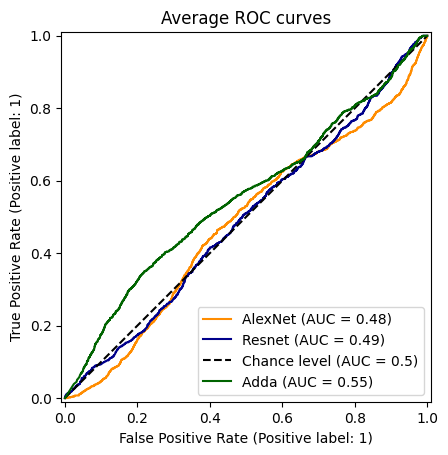

In [25]:
alexnet = AlexNet()
alexnet.load_state_dict(Alexnet )
alexnet = alexnet.cuda()

from ADDA.algorithms import supervised
from ADDA.networks import resnet
encoder = resnet.Encoder('18')
classifier = resnet.Classifier()

Resnet1 = supervised.Supervised(encoder,classifier)
Resnet1.encoder.load_state_dict(Resnet['encoder_weights'])
Resnet1.classifier.load_state_dict(Resnet['classifier_weights'])
source_encoder = resnet.Encoder('18')
target_encoder= resnet.Encoder('18')
from ADDA.algorithms import adda
from ADDA.networks import discriminator
classifier = resnet.Classifier()
discriminator = discriminator.Discriminator()
source_encoder.load_state_dict(ADDA['encoder_weights'])
classifier.load_state_dict(ADDA['classifier_weights'])
Adda= adda.Adda(source_encoder, target_encoder, classifier, discriminator)


plot_cm_roc(alexnet,Resnet1 ,Adda,test_dataloader_test2)

In [14]:
from torchvision import models
from torchsummary import summary

summary(alexnet,(100,1,150,150))


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 100, 1, 150, 150]

In [60]:
from torchinfo import summary
summary(alexnet, (100,1,150, 150))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [100, 3]                  --
├─Sequential: 1-1                        [100, 96, 17, 17]         --
│    └─Conv2d: 2-1                       [100, 96, 35, 35]         11,712
│    └─BatchNorm2d: 2-2                  [100, 96, 35, 35]         192
│    └─ReLU: 2-3                         [100, 96, 35, 35]         --
│    └─MaxPool2d: 2-4                    [100, 96, 17, 17]         --
├─Sequential: 1-2                        [100, 256, 8, 8]          --
│    └─Conv2d: 2-5                       [100, 256, 17, 17]        614,656
│    └─BatchNorm2d: 2-6                  [100, 256, 17, 17]        512
│    └─ReLU: 2-7                         [100, 256, 17, 17]        --
│    └─MaxPool2d: 2-8                    [100, 256, 8, 8]          --
├─Sequential: 1-3                        [100, 384, 8, 8]          --
│    └─Conv2d: 2-9                       [100, 384, 8, 8]          885,120